# Pfade und Laden

In [2]:
import os
import pandas as pd

# einfacher relativer Pfad vom Notebook aus
work_dir = "../audio_files/subsets/cv-corpus-de-23-working/de"
clips_dir = os.path.join(work_dir, "clips")
validated_tsv = os.path.join(work_dir, "validated.tsv")
durations_tsv = os.path.join(work_dir, "clip_durations.tsv")

df = pd.read_csv(validated_tsv, sep="\t", low_memory=False)
print(f"Datensatz geladen: {len(df):,} Zeilen, {len(df.columns)} Spalten")
df.head()

Datensatz geladen: 937,519 Zeilen, 13 Spalten


,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,00409eed11a98f906f8f1d553fc255db2c4696e8aabc4f...,common_voice_de_43373376.mp3,52bf0b838aff763308c1eb6ef8c1db23728f18ba1d085e...,Die Herkunft des Namens ist nicht eindeutig ge...,NaN,2,0,twenties,NaN,Deutschland Deutsch,NaN,de,NaN
1,0052c07533a6976233ad5926d950b523002c4d8cdd9ae8...,common_voice_de_17922420.mp3,bad5a1ff0fdae1d4d866b2772e2e10ccc553bc8d79565b...,Zieht euch bitte draußen die Schuhe aus.,NaN,2,0,NaN,NaN,NaN,NaN,de,NaN
2,00a997be768118523973bb8e5c3f2abaebe66587b0f3c1...,common_voice_de_40385660.mp3,4f5cd893325cc36b1d9cf514eda4ee628aeec9ffb7702f...,Vor wenigen Jahren war diese Vorstellung noch ...,NaN,3,0,NaN,NaN,NaN,NaN,de,NaN
3,00aa59ff387a07bf1c056cccd6715b3c764201f51092c3...,common_voice_de_27060918.mp3,36129a186d01d367a3a988d88a53f9ef4acd0f7dee2594...,Es gibt auch mehrere Campingplätze.,NaN,2,0,NaN,NaN,NaN,NaN,de,NaN
4,01644d63e19cee6f6d6896ef203d2e35202ecc2d42b2a8...,common_voice_de_36992722.mp3,479037bb9762b296baf361e763248b8374ffaf155fb487...,Als Kind wollte er nach eigenen Aussagen Footb...,NaN,3,0,NaN,NaN,NaN,NaN,de,NaN


# Summary

In [3]:
summary = {
    "anzahl_clips": len(df),
    "anzahl_sprecher": df["client_id"].nunique() if "client_id" in df.columns else None,
    "anzahl_sätze": df["sentence"].nunique() if "sentence" in df.columns else None,
    "durchschnitt_wörter_pro_satz": df["sentence"].astype(str).str.split().apply(len).mean(),
    "median_wörter_pro_satz": df["sentence"].astype(str).str.split().apply(len).median(),
}

pd.DataFrame([summary])

,anzahl_clips,anzahl_sprecher,anzahl_sätze,durchschnitt_wörter_pro_satz,median_wörter_pro_satz
0,937519,19353,641520,8.850267,9.0


# Clip Durations

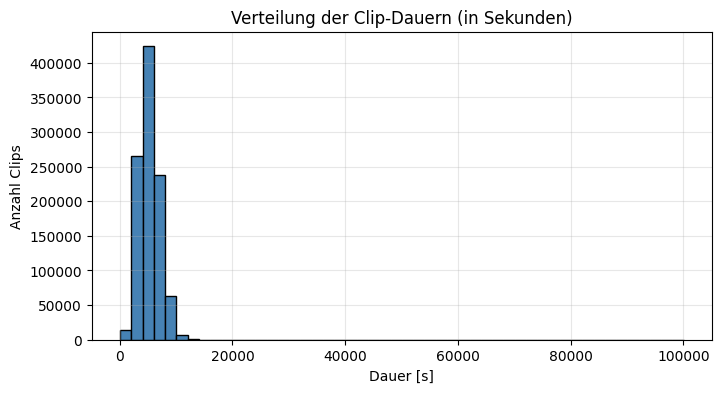

count    1.010623e+06
mean     5.261987e+03
std      1.786861e+03
min      7.200000e+01
25%      3.960000e+03
50%      5.112000e+03
75%      6.408000e+03
max      1.000800e+05
Name: duration[ms], dtype: float64

In [4]:
import matplotlib.pyplot as plt

# clip_durations.tsv laden
durations = pd.read_csv(durations_tsv, sep="\t")

# Sekunden-Spalte suchen (manchmal heißt sie 'duration' oder 'clip_length')
duration_col = [c for c in durations.columns if "duration" in c.lower() or "length" in c.lower()]
if duration_col:
    duration_col = duration_col[0]
else:
    raise ValueError("Keine Spalte mit Dauer gefunden.")

plt.figure(figsize=(8, 4))
plt.hist(durations[duration_col], bins=50, color="steelblue", edgecolor="black")
plt.title("Verteilung der Clip-Dauern (in Sekunden)")
plt.xlabel("Dauer [s]")
plt.ylabel("Anzahl Clips")
plt.grid(True, alpha=0.3)
plt.show()

durations[duration_col].describe()

In [6]:
# Annahme: durations["duration_s"] existiert bereits aus der vorherigen Zelle
thresholds = [10, 20, 30, 60, 120]  # Sekunden
total = len(durations)

stats = []
for t in thresholds:
    count = (durations["duration_s"] > t).sum()
    perc = 100 * count / total
    stats.append({"Schwelle [s]": t, "Clips > Schwelle": count, "Prozent": perc})

pd.DataFrame(stats)

,Schwelle [s],Clips > Schwelle,Prozent
0,10,8304,0.821671
1,20,17,0.001682
2,30,7,0.000693
3,60,4,0.000396
4,120,0,0.000000


Übrig: 1002319 / 1010623 Clips (99.18%)


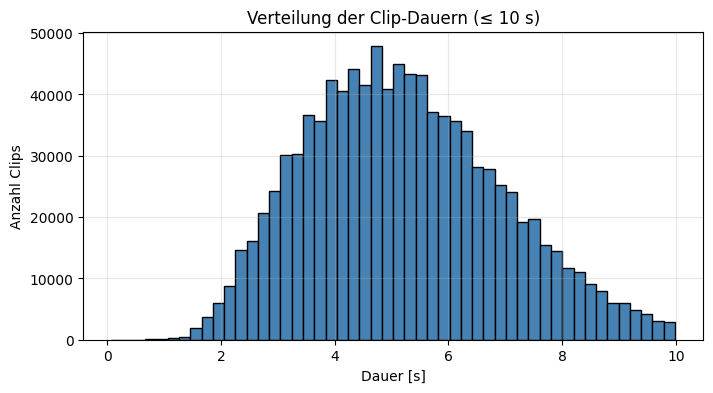

In [7]:
filtered_durations = durations[durations["duration_s"] <= 10].copy()
print(f"Übrig: {len(filtered_durations)} / {len(durations)} Clips ({100*len(filtered_durations)/len(durations):.2f}%)")

plt.figure(figsize=(8,4))
plt.hist(filtered_durations["duration_s"], bins=50, color="steelblue", edgecolor="black")
plt.title("Verteilung der Clip-Dauern (≤ 10 s)")
plt.xlabel("Dauer [s]")
plt.ylabel("Anzahl Clips")
plt.grid(True, alpha=0.3)
plt.show()

# Sprecher:innen Stats

Übersicht Altersangabe vs. fehlend:


,Kategorie,Anzahl Sprecher:innen
0,ohne Altersangabe,14890
1,mit Altersangabe,5077


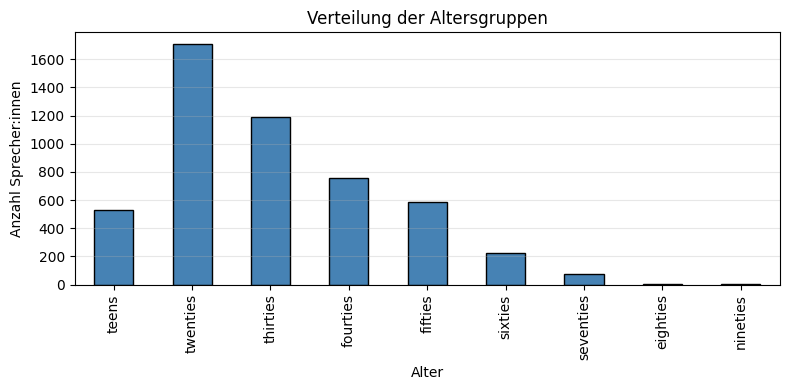

In [16]:
# Nur Sprecher:innen mit eindeutiger Alters-/Geschlechtsangabe
speaker_meta = merged[["client_id", "age", "gender"]].drop_duplicates()

# Übersicht: wie viele haben Altersangabe vs. nicht
age_nan_stats = speaker_meta["age"].isna().value_counts().rename({True: "ohne Altersangabe", False: "mit Altersangabe"})
age_nan_df = pd.DataFrame({"Kategorie": age_nan_stats.index, "Anzahl Sprecher:innen": age_nan_stats.values})
print("Übersicht Altersangabe vs. fehlend:")
display(age_nan_df)

# Altersverteilung (nur mit gültiger Angabe)
age_order = ["teens", "twenties", "thirties", "fourties", "fifties", "sixties", "seventies", "eighties", "nineties"]
age_counts = speaker_meta["age"].value_counts().reindex(age_order).dropna()

# Plot sortierte Altersverteilung (ohne NaN)
plt.figure(figsize=(8,4))
age_counts.plot(kind="bar", color="steelblue", edgecolor="black")
plt.title("Verteilung der Altersgruppen")
plt.xlabel("Alter")
plt.ylabel("Anzahl Sprecher:innen")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Verteilung der Sprecher:innen 

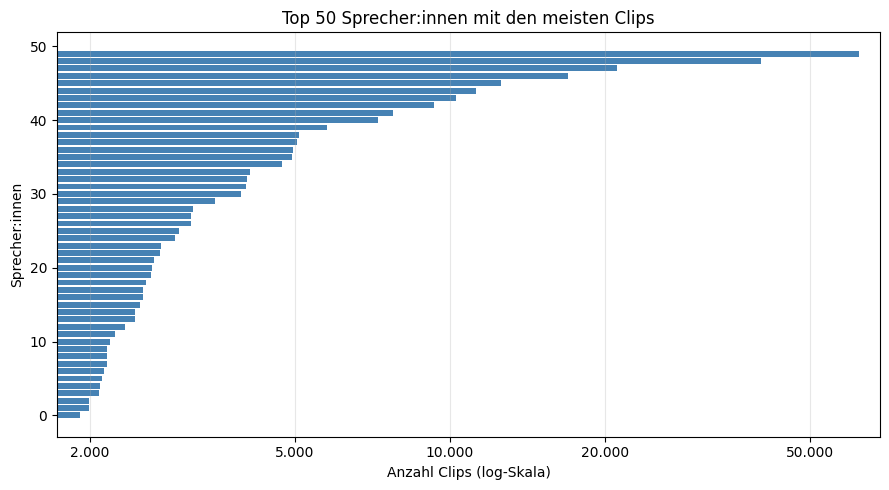

Sprecher:innen mit genau 1 Clip: 776 (4.02%)


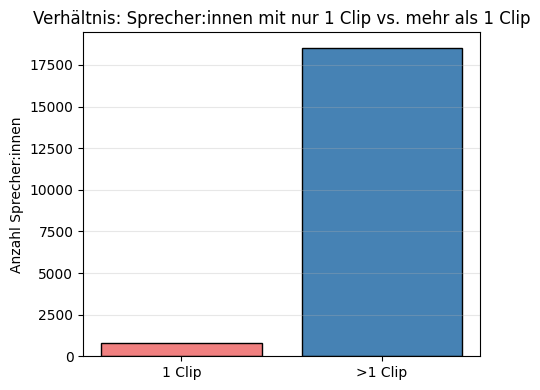

In [21]:
import matplotlib.ticker as ticker
import numpy as np

# Top 50 erneut bestimmen (falls Variable nicht im Scope)
top_50 = clips_per_speaker.sort_values(ascending=False).head(50)

vals = top_50.values
y_pos = np.arange(len(vals))

fig, ax = plt.subplots(figsize=(9,5))
ax.barh(y_pos, vals[::-1], color="steelblue")
ax.set_yscale("linear")
ax.set_xscale("log")

ax.set_title("Top 50 Sprecher:innen mit den meisten Clips")
ax.set_xlabel("Anzahl Clips (log-Skala)")
ax.set_ylabel("Sprecher:innen")

# Log-Ticks bei 1×, 2×, 5× 10^n
ax.xaxis.set_major_locator(ticker.LogLocator(base=10, subs=(1.0, 2.0, 5.0)))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f"{int(x):,}".replace(",", "."))
)

# sinnvolle Grenzen (kleiner Puffer)
xmin = max(vals.min() * 0.9, 1)   # nicht unter 1 gehen
xmax = vals.max() * 1.1
ax.set_xlim(xmin, xmax)

ax.grid(axis="x", alpha=0.3, which="major")
plt.tight_layout()
plt.show()

# --- Sprecher:innen mit nur 1 Clip ---
one_clip_count = (clips_per_speaker == 1).sum()
one_clip_percent = one_clip_count / len(clips_per_speaker) * 100

print(f"Sprecher:innen mit genau 1 Clip: {one_clip_count:,} ({one_clip_percent:.2f}%)")

# Plot: Anteil 1-Clip vs. Mehr-Clip Sprecher:innen
plt.figure(figsize=(5,4))
plt.bar(["1 Clip", ">1 Clip"], [one_clip_count, len(clips_per_speaker) - one_clip_count],
        color=["lightcoral", "steelblue"], edgecolor="black")
plt.title("Verhältnis: Sprecher:innen mit nur 1 Clip vs. mehr als 1 Clip")
plt.ylabel("Anzahl Sprecher:innen")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Clean up working directory

In [24]:
import os
import pandas as pd
from tqdm import tqdm

# --- Pfade ---
working_dir = "../audio_files/subsets/cv-corpus-de-23-working/de"
delta22_dir = "../audio_files/subsets/cv-corpus-22.0-delta-2025-06-20"
clips_dir = os.path.join(working_dir, "clips")

# --- TSV-Dateien laden ---
df_validated = pd.read_csv(os.path.join(working_dir, "validated.tsv"), sep="\t", low_memory=False)
df_delta22 = pd.read_csv(os.path.join(delta22_dir, "validated.tsv"), sep="\t", low_memory=False)
df_durations = pd.read_csv(os.path.join(working_dir, "clip_durations.tsv"), sep="\t")

print(f"Geladene Clips (v23): {len(df_validated)}")
print(f"Delta 22 Clips: {len(df_delta22)}")
print(f"Dauerinformationen: {len(df_durations)}")

# --- Spaltennamen angleichen ---
if "duration[ms]" in df_durations.columns:
    df_durations["duration_s"] = df_durations["duration[ms]"] / 1000.0
else:
    raise KeyError("Erwarte Spalte 'duration[ms]' in clip_durations.tsv")

# --- Nur validierte behalten (already validated.tsv) ---
# Schritt 1: Clips aus Delta22 entfernen
delta22_files = set(df_delta22["path"].str.strip().unique())
df_filtered = df_validated[~df_validated["path"].isin(delta22_files)]

# Schritt 2: Dauer <= 10 s
df_durations["clip"] = df_durations["clip"].str.strip()
valid_clips_under10 = df_durations[df_durations["duration_s"] <= 10]["clip"].unique()
df_filtered = df_filtered[df_filtered["path"].isin(valid_clips_under10)]

print(f"\nNach Filterung verbleibend: {len(df_filtered)} Clips")

# --- Dateien, die entfernt werden sollen ---
all_files = set(os.listdir(clips_dir))
keep_files = set(df_filtered["path"].str.strip().unique())
remove_files = all_files - keep_files

print(f"Dateien insgesamt: {len(all_files)}")
print(f"Zu behalten: {len(keep_files)}")
print(f"Zu entfernen: {len(remove_files)}")

# --- Sicherheitsabfrage ---
confirm = input("\nMöchtest du die nicht benötigten Dateien jetzt löschen? (ja/nein): ").strip().lower()
if confirm == "ja":
    for f in tqdm(remove_files, desc="Lösche ungenutzte Dateien"):
        try:
            os.remove(os.path.join(clips_dir, f))
        except FileNotFoundError:
            pass
    print(f"\n{len(remove_files)} Dateien gelöscht.")
else:
    print("\nLöschen übersprungen – es wurde nichts verändert.")

# --- Gefilterte TSV speichern ---
df_filtered.to_csv(os.path.join(working_dir, "validated_filtered.tsv"), sep="\t", index=False)
df_durations[df_durations["clip"].isin(valid_clips_under10)].to_csv(
    os.path.join(working_dir, "clip_durations_filtered.tsv"), sep="\t", index=False
)

print("\nGefilterte TSV-Dateien gespeichert:")
print(" - validated_filtered.tsv")
print(" - clip_durations_filtered.tsv")

Geladene Clips (v23): 937519
Delta 22 Clips: 2446
Dauerinformationen: 1010623

Nach Filterung verbleibend: 928894 Clips
Dateien insgesamt: 1010623
Zu behalten: 928894
Zu entfernen: 81729



Möchtest du die nicht benötigten Dateien jetzt löschen? (ja/nein):  ja


Lösche ungenutzte Dateien: 100%|████████| 81729/81729 [00:28<00:00, 2843.79it/s]



81729 Dateien gelöscht.

Gefilterte TSV-Dateien gespeichert:
 - validated_filtered.tsv
 - clip_durations_filtered.tsv


In [25]:
import pandas as pd

working_dir = "../audio_files/subsets/cv-corpus-de-23-working/de"
delta22_dir = "../audio_files/subsets/cv-corpus-22.0-delta-2025-06-20"

# Eingangsdatensätze laden
df_validated = pd.read_csv(os.path.join(working_dir, "validated.tsv"), sep="\t", low_memory=False)
df_delta22 = pd.read_csv(os.path.join(delta22_dir, "validated.tsv"), sep="\t", low_memory=False)
df_durations = pd.read_csv(os.path.join(working_dir, "clip_durations.tsv"), sep="\t")

# Dauer in Sekunden (falls noch nicht vorhanden)
if "duration_s" not in df_durations.columns:
    df_durations["duration_s"] = df_durations["duration[ms]"] / 1000.0

# Schritt 1: Gesamtzahl
total_clips = len(df_validated)

# Schritt 2: Entfernte durch Delta-22
delta22_files = set(df_delta22["path"].str.strip().unique())
removed_delta22 = df_validated[df_validated["path"].isin(delta22_files)]

# Schritt 3: Entfernte durch Längenfilter
long_clips = df_durations[df_durations["duration_s"] > 10]["clip"].unique()
removed_long = df_validated[df_validated["path"].isin(long_clips)]

# Schritt 4: Ergebnis nach Filtern
df_filtered = pd.read_csv(os.path.join(working_dir, "validated_filtered.tsv"), sep="\t")
remaining = len(df_filtered)

# Zusammenfassung
print("=== Filterstatistik ===")
print(f"Gesamtzahl (ursprünglich): {total_clips:,}")
print(f"Entfernt (Delta-22-Überlappung): {len(removed_delta22):,}")
print(f"Entfernt (Clips > 10 s): {len(removed_long):,}")
print(f"Verbleibend nach Filtern: {remaining:,}")
print(f"Prozent behalten: {remaining / total_clips * 100:.2f} %")

# Optional: in DataFrame speichern für spätere Doku
summary = pd.DataFrame({
    "Kategorie": ["Gesamt", "Entfernt Delta22", "Entfernt >10s", "Verbleibend"],
    "Anzahl": [total_clips, len(removed_delta22), len(removed_long), remaining],
    "Prozent_von_Gesamt": [100, len(removed_delta22)/total_clips*100,
                           len(removed_long)/total_clips*100, remaining/total_clips*100]
})
summary

=== Filterstatistik ===
Gesamtzahl (ursprünglich): 937,519
Entfernt (Delta-22-Überlappung): 2,443
Entfernt (Clips > 10 s): 6,258
Verbleibend nach Filtern: 928,894
Prozent behalten: 99.08 %


/var/folders/20/0f1z0fvn1hvgz14x2k0l0zz00000gn/T/ipykernel_9790/2715390954.py:27: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_filtered = pd.read_csv(os.path.join(working_dir, "validated_filtered.tsv"), sep="\t")


,Kategorie,Anzahl,Prozent_von_Gesamt
0,Gesamt,937519,100.000000
1,Entfernt Delta22,2443,0.260581
2,Entfernt >10s,6258,0.667506
3,Verbleibend,928894,99.080019


# Balancing der Sprecher:innen

In [26]:
import os
import pandas as pd

# Pfade
working_dir = "../audio_files/subsets/cv-corpus-de-23-working/de"
delta22_dir = "../audio_files/subsets/cv-corpus-22.0-delta-2025-06-20"

# TSVs laden
df_validated = pd.read_csv(os.path.join(working_dir, "validated.tsv"), sep="\t", low_memory=False)
df_delta22 = pd.read_csv(os.path.join(delta22_dir, "validated.tsv"), sep="\t", low_memory=False)

print(f"Ausgangsdaten (v23 validated): {len(df_validated):,}")
print(f"Sprecher:innen in Delta-22: {df_delta22['client_id'].nunique():,}")

# 1. Sprecher:innen aus Delta-22 entfernen
delta22_clients = set(df_delta22["client_id"].dropna().unique())
df_filtered = df_validated[~df_validated["client_id"].isin(delta22_clients)].copy()

print(f"Nach Entfernen überlappender Sprecher:innen: {len(df_filtered):,} Clips")
print(f"Verbleibende Sprecher:innen: {df_filtered['client_id'].nunique():,}")

# 2. Pro Sprecher:in max. 50 Clips behalten
def sample_clips(group, n=50):
    if len(group) <= n:
        return group
    return group.sample(n=n, random_state=42)

df_balanced = df_filtered.groupby("client_id", group_keys=False).apply(sample_clips, n=50)

print(f"Nach Begrenzung auf max. 50 Clips/Sprecher: {len(df_balanced):,} Clips")
print(f"Verbleibende Sprecher:innen: {df_balanced['client_id'].nunique():,}")

# 3. Neue balanced TSV speichern
balanced_path = os.path.join(working_dir, "validated_balanced.tsv")
df_balanced.to_csv(balanced_path, sep="\t", index=False)
print(f"Gespeichert unter: {balanced_path}")

Ausgangsdaten (v23 validated): 937,519
Sprecher:innen in Delta-22: 318
Nach Entfernen überlappender Sprecher:innen: 880,408 Clips
Verbleibende Sprecher:innen: 19,035
Nach Begrenzung auf max. 50 Clips/Sprecher: 288,655 Clips
Verbleibende Sprecher:innen: 19,035
Gespeichert unter: ../audio_files/subsets/cv-corpus-de-23-working/de/validated_balanced.tsv


In [27]:
import os
import glob

clips_dir = os.path.join(working_dir, "clips")
balanced_tsv = os.path.join(working_dir, "validated_balanced.tsv")

# Eingelesene balanced-Datei
df_balanced = pd.read_csv(balanced_tsv, sep="\t", low_memory=False)
valid_files = set(df_balanced["path"].astype(str).str.strip())

# Alle Audiodateien im Ordner finden
all_audio_files = glob.glob(os.path.join(clips_dir, "*.mp3"))
print(f"Gesamtanzahl Audiodateien im Ordner: {len(all_audio_files):,}")

# Filter: Nur behalten, was in der balanced TSV steht
to_delete = [f for f in all_audio_files if os.path.basename(f) not in valid_files]
print(f"Dateien zum Löschen: {len(to_delete):,}")

# Sicherheitsabfrage (optional)
if len(to_delete) > 0:
    for path in to_delete:
        try:
            os.remove(path)
        except Exception as e:
            print(f"Fehler beim Löschen: {path} ({e})")

print("Fertig! Nur noch Clips aus validated_balanced.tsv sind vorhanden.")

Gesamtanzahl Audiodateien im Ordner: 928,894
Dateien zum Löschen: 642,181
Fertig! Nur noch Clips aus validated_balanced.tsv sind vorhanden.


In [29]:
import os
import pandas as pd

# Pfade
balanced_tsv = "../audio_files/subsets/cv-corpus-de-23-working/de/validated_balanced.tsv"
clips_dir = "../audio_files/subsets/cv-corpus-de-23-working/de/clips"

# TSV laden
df_bal = pd.read_csv(balanced_tsv, sep="\t", low_memory=False)
df_bal["path"] = df_bal["path"].astype(str).str.strip()

# Existierende Dateien sammeln
existing_files = set(os.listdir(clips_dir))
expected_files = set(df_bal["path"])

# Fehlende Dateien ermitteln
missing_files = expected_files - existing_files

print(f"Fehlende Dateien laut TSV: {len(missing_files)}")
print("\nBeispielhafte fehlende Pfade:")
for f in list(missing_files)[:10]:
    print("  ", f)

Fehlende Dateien laut TSV: 1942

Beispielhafte fehlende Pfade:
   common_voice_de_19666242.mp3
   common_voice_de_28812249.mp3
   common_voice_de_28709497.mp3
   common_voice_de_27023380.mp3
   common_voice_de_41450719.mp3
   common_voice_de_19119737.mp3
   common_voice_de_33457160.mp3
   common_voice_de_22187718.mp3
   common_voice_de_20747062.mp3
   common_voice_de_28765955.mp3


In [30]:
import pandas as pd
import os

# Pfade
balanced_tsv = "../audio_files/subsets/cv-corpus-de-23-working/de/validated_balanced.tsv"
clips_dir = "../audio_files/subsets/cv-corpus-de-23-working/de/clips"

# TSV laden
df_bal = pd.read_csv(balanced_tsv, sep="\t", low_memory=False)
df_bal["path"] = df_bal["path"].astype(str).str.strip()

# Liste existierender Dateien
existing_files = set(os.listdir(clips_dir))

# Nur behalten, was physisch vorhanden ist
df_bal_filtered = df_bal[df_bal["path"].isin(existing_files)].copy()

# Neue Datei speichern
out_path = "../audio_files/subsets/cv-corpus-de-23-working/de/validated_balanced_clean.tsv"
df_bal_filtered.to_csv(out_path, sep="\t", index=False)

print(f"Vorher: {len(df_bal)} Zeilen")
print(f"Nachher: {len(df_bal_filtered)} Zeilen")
print(f"Gespeichert unter: {out_path}")

Vorher: 288655 Zeilen
Nachher: 286713 Zeilen
Gespeichert unter: ../audio_files/subsets/cv-corpus-de-23-working/de/validated_balanced_clean.tsv


# Analyse nach Bereinigen des Datasets

Datensatz geladen: 286,713 Zeilen
Spalten: ['client_id', 'path', 'sentence_id', 'sentence', 'sentence_domain', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment']


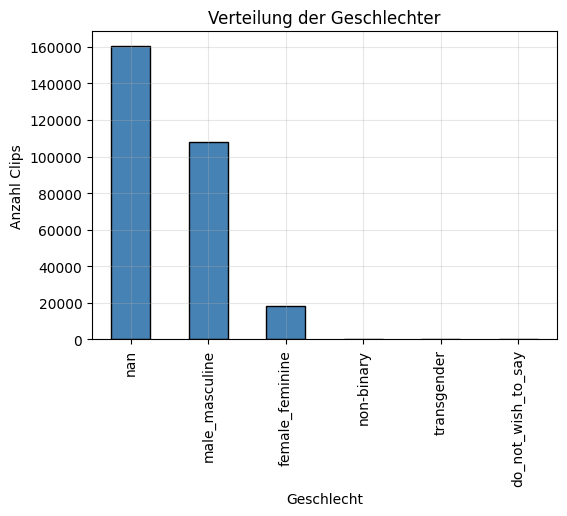

,Kategorie,Anzahl Clips
0,mit Altersangabe,128725
1,ohne Altersangabe,157988


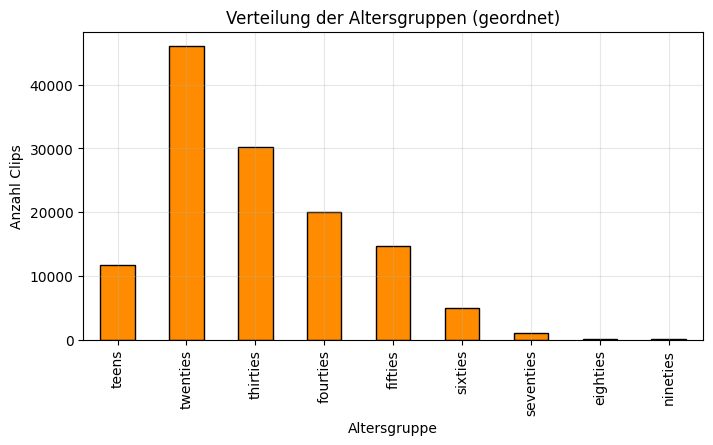

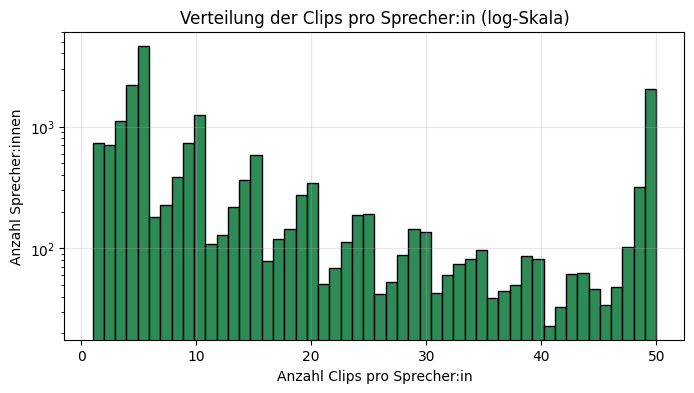

Grundstatistik – Clips pro Sprecher:in:
count    18997.000000
mean        15.092541
std         16.119538
min          1.000000
25%          4.000000
50%          6.000000
75%         20.000000
max         50.000000
Name: count, dtype: float64


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Bereinigte TSV laden
validated_clean_path = "../audio_files/subsets/cv-corpus-de-23-working/de/validated_balanced_clean.tsv"
df = pd.read_csv(validated_clean_path, sep="\t", low_memory=False)

print(f"Datensatz geladen: {len(df):,} Zeilen")
print("Spalten:", list(df.columns))

# --- Geschlecht ---
plt.figure(figsize=(6,4))
df["gender"].value_counts(dropna=False).plot(kind="bar", color="steelblue", edgecolor="black")
plt.title("Verteilung der Geschlechter")
plt.xlabel("Geschlecht")
plt.ylabel("Anzahl Clips")
plt.grid(True, alpha=0.3)
plt.show()

import pandas as pd
import matplotlib.pyplot as plt

validated_clean_path = "../audio_files/subsets/cv-corpus-de-23-working/de/validated_balanced_clean.tsv"
df = pd.read_csv(validated_clean_path, sep="\t", low_memory=False)

# Reihenfolge der Altersgruppen manuell definieren
age_order = [
    "teens", "twenties", "thirties", "fourties", "fifties",
    "sixties", "seventies", "eighties", "nineties"
]

# Aufteilen in gültige Altersangaben und NaN
age_counts = df["age"].value_counts(dropna=False)
has_age = age_counts[age_counts.index.notna()].sum()
missing_age = age_counts[age_counts.index.isna()].sum()

# Übersichtstabelle
age_overview = pd.DataFrame({
    "Kategorie": ["mit Altersangabe", "ohne Altersangabe"],
    "Anzahl Clips": [has_age, missing_age]
})
display(age_overview)

# Altersverteilung plotten
age_counts_valid = df["age"].dropna().value_counts().reindex(age_order).fillna(0)

plt.figure(figsize=(8,4))
age_counts_valid.plot(kind="bar", color="darkorange", edgecolor="black")
plt.title("Verteilung der Altersgruppen (geordnet)")
plt.xlabel("Altersgruppe")
plt.ylabel("Anzahl Clips")
plt.grid(True, alpha=0.3)
plt.show()

# --- Clips pro Sprecher ---
clips_per_speaker = df["client_id"].value_counts()
plt.figure(figsize=(8,4))
plt.hist(clips_per_speaker, bins=50, color="seagreen", edgecolor="black")
plt.yscale("log")
plt.title("Verteilung der Clips pro Sprecher:in (log-Skala)")
plt.xlabel("Anzahl Clips pro Sprecher:in")
plt.ylabel("Anzahl Sprecher:innen")
plt.grid(True, alpha=0.3)
plt.show()

# --- Grundstatistik ---
print("Grundstatistik – Clips pro Sprecher:in:")
print(clips_per_speaker.describe())

# Sprecher:innen aus Delta 22 entfernen

In [33]:
import pandas as pd

# Pfade
validated_balanced_clean = "../audio_files/subsets/cv-corpus-de-23-working/de/validated_balanced_clean.tsv"
delta_22_validated = "../audio_files/subsets/cv-corpus-22.0-delta-2025-06-20/validated.tsv"
output_path = "../audio_files/subsets/cv-corpus-de-23-working/de/validated_balanced_final.tsv"

# Laden
df_clean = pd.read_csv(validated_balanced_clean, sep="\t", low_memory=False)
df_delta = pd.read_csv(delta_22_validated, sep="\t", low_memory=False)

# Sprecher-IDs aus Delta 22 extrahieren
delta_speakers = set(df_delta["client_id"].unique())

# Vorher
clips_before = len(df_clean)
speakers_before = df_clean["client_id"].nunique()

# Entfernen
df_final = df_clean[~df_clean["client_id"].isin(delta_speakers)].copy()

# Nachher
clips_after = len(df_final)
speakers_after = df_final["client_id"].nunique()

print(f"Sprecher:innen entfernt: {speakers_before - speakers_after}")
print(f"Clips entfernt: {clips_before - clips_after}")
print(f"Verbleibende Sprecher:innen: {speakers_after}")
print(f"Verbleibende Clips: {clips_after}")

# Speichern
df_final.to_csv(output_path, sep="\t", index=False)
print(f"\nGespeichert unter: {output_path}")

Sprecher:innen entfernt: 0
Clips entfernt: 0
Verbleibende Sprecher:innen: 18997
Verbleibende Clips: 286713

Gespeichert unter: ../audio_files/subsets/cv-corpus-de-23-working/de/validated_balanced_final.tsv
